In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import string
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /Users/pacheng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/pacheng/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/pacheng/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/pacheng/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [4]:
from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

In [5]:
def get_names(text):
    '''
    extract people names from input block of string
    :article: the input string
    :return: a list of string representing people names, organizations, and locations
    '''
    assert isinstance(text, str)
    # remove stop word from text
    text = " ".join([i for i in text.split() if i not in stop_words])
    # get tokens from text
    tokens = nltk.tokenize.word_tokenize(text)
    # get part of speech tag
    pos = nltk.pos_tag(tokens)
    names = []
    organizations = []
    locations = []
    # indentify name entities
    for chunk in nltk.ne_chunk(pos, binary = False):
        if type(chunk) == nltk.tree.Tree:
            if chunk.label() == 'ORGANIZATION':
                organizations.append(' '.join([c[0] for c in chunk]))
            if chunk.label() == 'PERSON':
                names.append(' '.join([c[0] for c in chunk]))
            if chunk.label() == 'GPE':
                locations.append(' '.join([c[0] for c in chunk]))
    return names
    

In [6]:
def get_all_names(articles):
    '''
    build a map of name to its mentinon frequency(string->int), and then draw a bar chart
    :articles: a list of articles, each article is a string representing the content
    :n: the top n names, int
    :return: return a list of all the names, orgnizations, lcoations in articles
    '''
    assert isinstance(articles, list), "the input articles should a be string list"
    
    # dictionary for all the name->mention frequency
    all_name = []
    for article in articles:
        # get all the names in the article, a string list
        if type(article) == str:
            name, org, loc = get_names(article)
            # add to name_counter dictionary
            all_name.extend(name)
    return all_name

In [7]:
import pandas as pd
tr_data = pd.read_csv('./Datasets/train.csv')
test_data = pd.read_csv('./Datasets/test.csv')
test_label = pd.read_csv('./Datasets/test_data_labels.csv')
test_data = pd.merge(test_data, test_label, on = 'id')
all_data = pd.concat([tr_data, test_data])

In [12]:
# 1-unreliable 0- reliable
fakeTexts = all_data['text'][all_data.label == 1].to_list()
realTexts = all_data['text'][all_data.label == 0].to_list()

In [14]:
import time
t0 = time.time()
real_name = get_all_names(realTexts)
fake_name = get_all_names(fakeTexts[0:len(realTexts)])
t1 = time.time()
print((t1-t0)/60)

19.148472932974496


In [15]:
# save the data to file system for future use
# so do not need to do name extraction everytime which takes much time
tmp = pd.DataFrame(real_name, columns = ['name'])
tmp.to_csv('./Datasets/real_name.csv')


tmp = pd.DataFrame(fake_name, columns = ['name'])
tmp.to_csv('./Datasets/fake_name.csv')

In [113]:
# read from file to build the figures
real_data = pd.read_csv('./Datasets/real_name.csv')
real_name = real_data['name'].to_list()
# print(len(real_name))

fake_data = pd.read_csv('./Datasets/fake_name.csv')
fake_name = fake_data['name'].to_list()
# print(len(fake_name))

In [114]:
# merge names
# Mr. Trump, Trump -> Donald Trump
real_name = ['Donald Trump' if (name == 'Mr. Trump' or name == 'Trump' or name == 'Donald J. Trump') 
             else name for name in real_name]
real_name = ['Barack Obama' if (name == 'Obama' or name == 'Mr. Obama') 
             else name for name in real_name]

real_name = ['Clinton' if name == 'Hillary' or name == 'Hillary Clinton' or name == 'Bill' or name == 'Bill Clinton' 
             or name == 'Clintons' else name for name in real_name]

fake_name = ['Donald Trump' if (name == 'Mr. Trump' or name == 'Trump' or name == 'Donald J. Trump') 
             else name for name in fake_name]
fake_name = ['Barack Obama' if (name == 'Obama' or name == 'Mr. Obama') 
             else name for name in fake_name]
fake_name = ['Clinton' if name == 'Hillary' or name == 'Hillary Clinton' or name == 'Bill' or name == 'Bill Clinton' 
             or name == 'Clintons' else name for name in fake_name]

In [115]:
def get_common_name(names, n):
    '''
    :name: a list of names string
    :n: the most common n names
    :return: a dict of the most common n names
    '''
    assert isinstance(names, list), "input should be a list"
#     assert all(isinstance(name, str) for name in names)
    assert isinstance(n, int), "n should be a positive integer"
    from collections import Counter 
    nameCounter = Counter(names)
    most_common_names = nameCounter.most_common(n) 
    return most_common_names

In [116]:
def most_commom_names_bar(names, n, label):
    
    '''
    This function returns a bar graph of n most common words from an article.
    Input: data is an article string; n is the number of most commom words
    Output: a bargraph: x-axis is each word; y-axis is the number of times each word appears in the article
    '''
    
    assert isinstance(names, list)
    assert isinstance(n, int) and n > 0
    assert isinstance(label, str)
    assert label in ['real', 'fake']
    
    import matplotlib.pyplot as plt
    
    most_common_dic = {}
    for item in names:
        most_common_dic[item[0]] = item[1]
    
    dic = most_common_dic
    word = list(dic.keys())
    num = list(dic.values())
    word = word[0:n]
    num = num[0:n]
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(word,num)
    plt.title('Most {} common names in {} articles'.format(n, label),fontsize=15)
    plt.xlabel('Names',fontsize=15)
    plt.ylabel('# Mentions',fontsize=15)
    plt.xticks(rotation=60)
    plt.xticks(size = 12)
    plt.yticks(size = 15)
    plt.show()

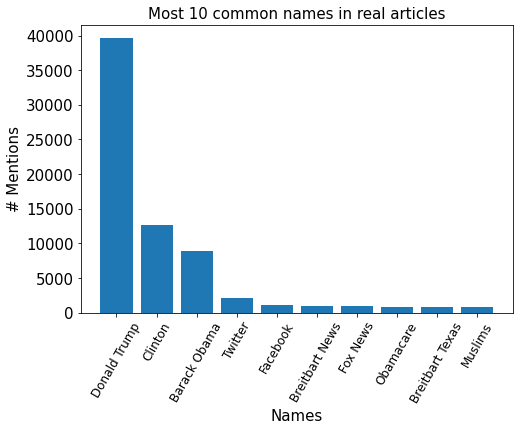

In [117]:
common_real_name = get_common_name(real_name, 1000)
most_commom_names_bar(common_real_name, 10, 'real')

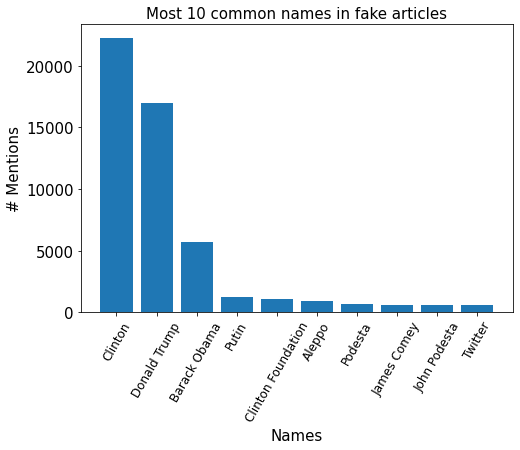

In [118]:
common_fake_name = get_common_name(fake_name, 1000)
most_commom_names_bar(common_fake_name, 10, 'fake')

In [121]:
# build a side-by-side char bar, compare #mentions of names in real and fake articles

def comparison_barchart(common_real_name, common_fake_name):
    '''
    build a side-by-side char bar, compare #mentions of names in real and fake articles
    :common_real_name: a list of size 2 tuple, each tuple contains name in real articles and # mention
    :common_fake_name: a list of size 2 tuple, each tuple contains name in fake articles and # mention
    '''
    names = []
    real_name_count = []
    fake_name_count = []

    common_real_name_dic = {}
    common_fake_name_dic = {}
    for item in common_real_name:
        common_real_name_dic[item[0]] = item[1]

    for item in common_fake_name:
        common_fake_name_dic[item[0]] = item[1]

    for name in common_real_name_dic.keys():
        if len(names) == 10:
            break
        if name in common_fake_name_dic.keys():
            names.append(name)
            real_name_count.append(common_real_name_dic[name])
            fake_name_count.append(common_fake_name_dic[name])
    
    size = len(names)
    import numpy as np
    x = np.arange(size)
    a = real_name_count
    b = fake_name_count

    total_width, n = 0.8, 2
    width = total_width / n
    x = x - (total_width - width) / 2
    plt.figure(figsize=(16,8))

    plt.bar(names, a,  width=width, label='name in real articles')
    plt.bar(x + width+0.2, b, width=width, label='name in fake articles')
    plt.title('Real Name vs Fake Names',fontsize=20)
    plt.xlabel('names',fontsize=20)
    plt.ylabel('# Mentions',fontsize=20)
    plt.xticks(rotation=50)
    plt.xticks(size = 20)
    plt.yticks(size = 15)
    plt.legend(fontsize=20)
    plt.show()
        

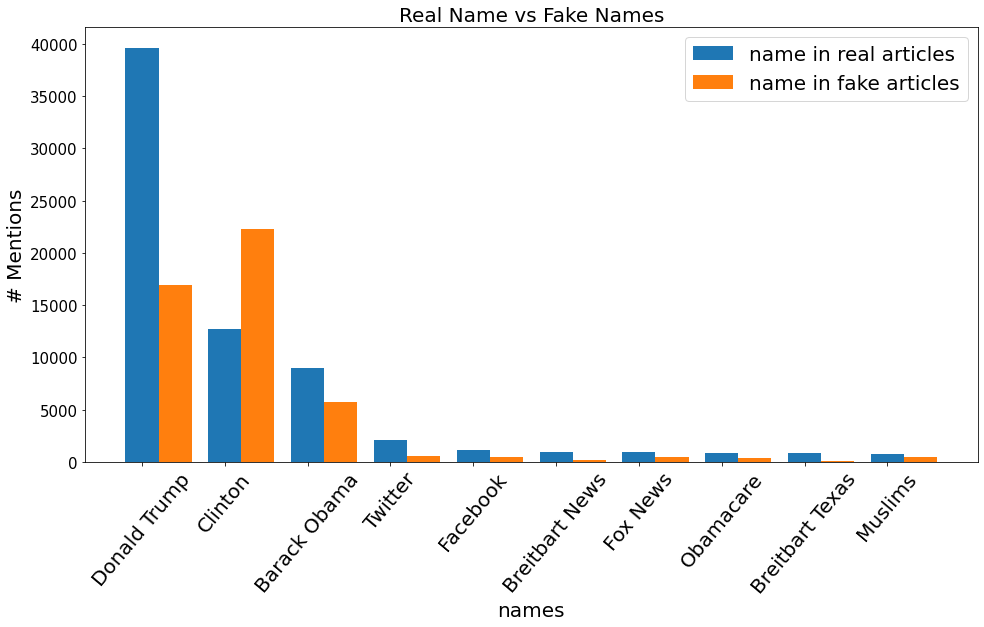

In [122]:
comparison_barchart(common_real_name, common_fake_name)